# Satelite Data

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

from IPython.display import display, clear_output
from ipywidgets import FloatProgress, HTML
%matplotlib notebook

In [37]:

# Time = 14
def SunStas(LAT,LON,JD,TIME,TZ):
    F2 = JD+TIME/24-TZ/24 ## Use PD.to_julian
#     F2 = JD-TZ/24 ## Use PD.to_julian
    G2 = (F2-2451545)/36525 #Julian Century

    I2 = (280.46646+G2*(36000.76983 + G2*0.0003032))%360 #Geom Mean Long Sun (deg)
    J2 = 357.52911+G2*(35999.05029 - 0.0001537*G2)#Geom Mean Anom Sun (deg)
    K2 = 0.016708634-G2*(0.000042037+0.0000001267*G2)#Eccent Earth Orbit
    L2 = np.sin(np.radians(J2))*(1.914602-G2*(0.004817+0.000014*G2))+np.sin(np.radians(2*J2))*(0.019993-0.000101*G2)+np.sin(np.radians(3*J2))*0.000289 #Sun Eq of Ctr
    M2 = I2+L2 #Sun True Long (deg)
    N2 = J2+L2 #Sun True Anom (deg)
    O2 = (1.000001018*(1-K2*K2))/(1+K2*np.cos(np.radians(N2))) #Sun Rad Vector (AUs)
    P2 = M2-0.00569-0.00478*np.sin(np.radians(125.04-1934.136*G2)) #Sun App Long (deg)
    Q2 = 23+(26+((21.448-G2*(46.815+G2*(0.00059-G2*0.001813))))/60)/60 #Mean Obliq Ecliptic (deg)
    R2 = Q2+0.00256*np.cos(np.radians(125.04-1934.136*G2)) #Obliq Corr (deg)
    S2 = np.radians(np.arctan2(np.cos(np.radians(R2))*np.sin(np.radians(P2)),np.cos(np.radians(P2)))) #Sun Rt Ascen (deg)
    T2 = np.degrees(np.arcsin(np.sin(np.radians(R2))*np.sin(np.radians(P2)))) #Sun Declin (deg)
    U2 = np.tan(np.radians(R2/2))*np.tan(np.radians(R2/2))# var y
    V2 = 4*np.degrees(U2*np.sin(2*np.radians(I2))-2*K2*np.sin(np.radians(J2))+4*K2*U2*np.sin(np.radians(J2))*np.cos(2*np.radians(I2))-0.5*U2*U2*np.sin(4*np.radians(I2))-1.25*K2*K2*np.sin(2*np.radians(J2))) #Eq of Time (minutes)
    W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)

    X2 = (720-4*LON-V2+TZ*60)/1440 #Solar Noon (LST)
    Sunrise = (X2*1440-W2*4)/1440 #Sunrise Time (LST)
    Sunset = (X2*1440+W2*4)/1440 #Sunset Time (LST)

    AA2=8*W2 #Sunlight Duration (minutes)
    AB2=(TIME*1440+V2+4*LON-60*TZ)%1440 # True Solar Time (min)

    if AB2/4<0:
        AC2=AB2/4+180# Hour Angle (deg)
    else:
        AC2=AB2/4-180# Hour Angle (deg)

    Zenith = np.degrees(np.arccos(np.sin(np.radians(LAT))*np.sin(np.radians(T2))+np.cos(np.radians(LAT))*np.cos(np.radians(T2))*np.cos(np.radians(AC2))))# Solar Zenith Angle (deg)

    # np.degrees(ACOS(SIN(np.radians($B$2))*SIN(np.radians(T2))+COS(np.radians($B$2))*COS(np.radians(T2))*COS(np.radians(AC2))))

    Angle = 90-Zenith #Solar Elevation Angle (deg)
#     AF2 = 0/3600
    if Angle>85:
        AF2 = 0
    elif Angle>5:
        AF2 = 58.1/np.tan(np.radians(Angle))-0.07/((np.tan(np.radians(Angle)))**3)+0.000086/(np.tan(np.radians(Angle))**5)
    elif Angle>-0.575:
        AF2 = 1735+Angle*(-518.2+Angle*(103.4+Angle*(-12.79+Angle*0.711)))
    else:
        AF2 = -20.772/np.tan(np.radians(Angle))
    AF2/=3600#pprox Atmospheric Refraction (deg)
    Angle_Corr = Angle+AF2 #Solar Elevation corrected for atm refraction (deg)

    if AC2>0:
        Azimuth = (np.degrees(np.arccos(((np.sin(np.radians(LAT))*np.cos(np.radians(Zenith)))-np.sin(np.radians(T2)))/(np.cos(np.radians(LAT))*np.sin(np.radians(Zenith)))))+180)%360
    else:
        Azimuth = (540-np.degrees(np.arccos(((np.sin(np.radians(LAT))*np.cos(np.radians(Zenith)))-np.sin(np.radians(T2)))/(np.cos(np.radians(LAT))*np.sin(np.radians(Zenith))))))%360
    # Solar Azimuth Angle (deg cw from N)
    return(Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset)


In [38]:
NDVI_FishIsland = pd.read_csv('NDVI_MODIS.csv',parse_dates=['Date'])
NDVI_FishIsland = NDVI_FishIsland.set_index(pd.DatetimeIndex(NDVI_FishIsland['Date']))
NDVI_FishIsland=NDVI_FishIsland.drop('Date',axis=1)
NDVI_Landsat7 = pd.read_csv('Landsat7_NDVI.csv',parse_dates=['Date'])
NDVI_Landsat7 = NDVI_Landsat7.set_index(pd.DatetimeIndex(NDVI_Landsat7['Date']))
NDVI_Landsat7=NDVI_Landsat7.drop('Date',axis=1)
NDVI_Landsat8 = pd.read_csv('Landsat8_NDVI.csv',parse_dates=['Date'])
NDVI_Landsat8 = NDVI_Landsat8.set_index(pd.DatetimeIndex(NDVI_Landsat8['Date']))
NDVI_Landsat8=NDVI_Landsat8.drop('Date',axis=1)
NDVI_Landsat8_Comp = pd.read_csv('Landsat8_NDVI_8Day_Composite.csv',parse_dates=['Date'])
NDVI_Landsat8_Comp = NDVI_Landsat8_Comp.set_index(pd.DatetimeIndex(NDVI_Landsat8_Comp['Date']))
NDVI_Landsat8_Comp=NDVI_Landsat8_Comp.drop('Date',axis=1)
Snow = pd.read_csv('Snow_Cover_FishIsland.csv',parse_dates=['Date'])#NDSI_Snow_Cover
Snow = Snow.set_index(pd.DatetimeIndex(Snow['Date']))
Snow=Snow.drop('Date',axis=1)

Data = NDVI_FishIsland.copy()
Data = Data.join(NDVI_Landsat7,how='outer')
Data = Data.join(NDVI_Landsat8,how='outer')
Data = Data.join(NDVI_Landsat8_Comp,how='outer')
print(Data.index)
print(Snow.index)
Data = Data.join(Snow,how='outer')
# Data.loc[((Data['NDVI_FishIsland']>Data['NDVI_FishIsland'].quantile(.98))|
#           (Data['NDVI_FishIsland']<Data['NDVI_FishIsland'].quantile(.02))),'NDVI_FishIsland']=np.nan

# Data.loc[((Data['NDVI_Landsat8']>Data['NDVI_Landsat8'].quantile(.98))|
#           (Data['NDVI_Landsat8']<Data['NDVI_Landsat8'].quantile(.02))),'NDVI_Landsat8']=np.nan
Data['DOY'] = Data.index.dayofyear
print(Data.index)

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2021-03-22', '2021-03-25', '2021-03-26', '2021-03-27',
               '2021-03-30', '2021-04-07', '2021-04-15', '2021-04-23',
               '2021-05-01', '2021-05-09'],
              dtype='datetime64[ns]', name='Date', length=4773, freq=None)
DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05',
               '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09',
               '2021-07-10', '2021-07-11'],
              dtype='datetime64[ns]', name='Date', length=4930, freq=None)
DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',

In [50]:
# print(Data[['NDSI_Snow_Cover_Footprint','NDSI_Snow_Cover_FishIsland','NDSI_Snow_Cover_BigLake']].corr())
# print(Data[['NDSI_Snow_Cover_Footprint','NDSI_Snow_Cover_FishIsland','NDSI_Snow_Cover_BigLake']].describe())

# # plt.scatter(Data['NDSI_Snow_Cover_Footprint'],Data['NDSI_Snow_Cover_BigLake'],label='fp v. bl')
# plt.scatter(Data['NDSI_Snow_Cover_Footprint'],Data['NDSI_Snow_Cover_FishIsland'],label='fp v. fi')
# from sklearn import metrics
# Temp = Data[['NDSI_Snow_Cover_Footprint','NDSI_Snow_Cover_FishIsland','NDSI_Snow_Cover_BigLake']].dropna()
# print(metrics.r2_score(Temp['NDSI_Snow_Cover_Footprint'],Temp['NDSI_Snow_Cover_FishIsland']))
# print(metrics.r2_score(Temp['NDSI_Snow_Cover_Footprint'],Temp['NDSI_Snow_Cover_BigLake']))
# print(metrics.r2_score(Temp['NDSI_Snow_Cover_FishIsland'],Temp['NDSI_Snow_Cover_BigLake']))
# # print(metrics.mean_squared_error(Temp['NDSI_Snow_Cover_Footprint'],Temp['NDSI_Snow_Cover_FishIsland']))
# # plt.scatter(Data['NDSI_Snow_Cover_FishIsland'],Data['NDSI_Snow_Cover_BigLake'],label='fi v. bl')
# plt.legend()

In [51]:
# print(Data[['NDVI_FishIsland','NDVI_Footprint']].corr())
# print(Data[['NDVI_FishIsland','NDVI_Footprint']].describe())
# plt.figure()
# plt.scatter(Data['NDVI_Footprint'],Data['NDVI_FishIsland'],label='fp v. fi')
# Temp = Data[['NDVI_Footprint','NDVI_FishIsland']].dropna()
# print(metrics.r2_score(Temp['NDVI_Footprint'],Temp['NDVI_FishIsland']))

0.9565173610643355
-0.5363966316257134
[1.01292693]


<IPython.core.display.Javascript object>


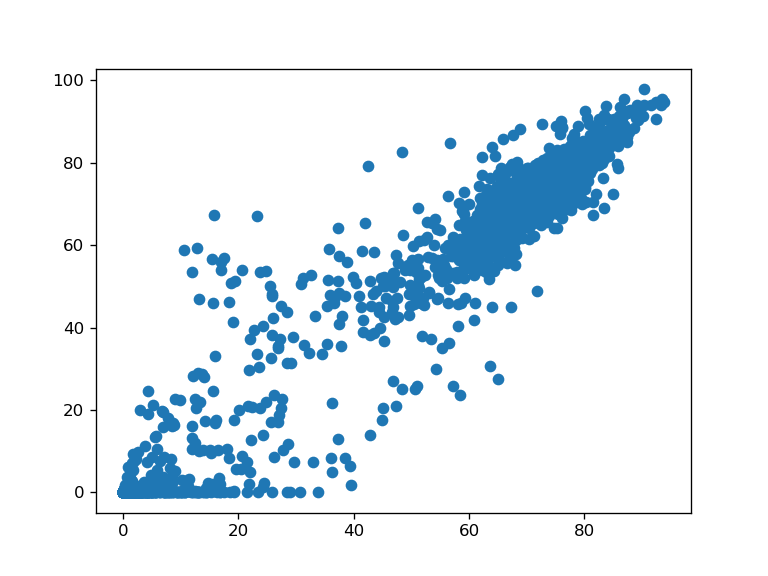

       NDSI_Snow_Cover      FI_Snow
count      2064.000000  3852.000000
mean         38.626762    38.625219
std          35.071043    33.933803
min           0.000000     0.000000
25%           0.000000     0.019000
50%          50.206000    49.751062
75%          72.224000    70.588000
max          97.810000    97.810000


<IPython.core.display.Javascript object>


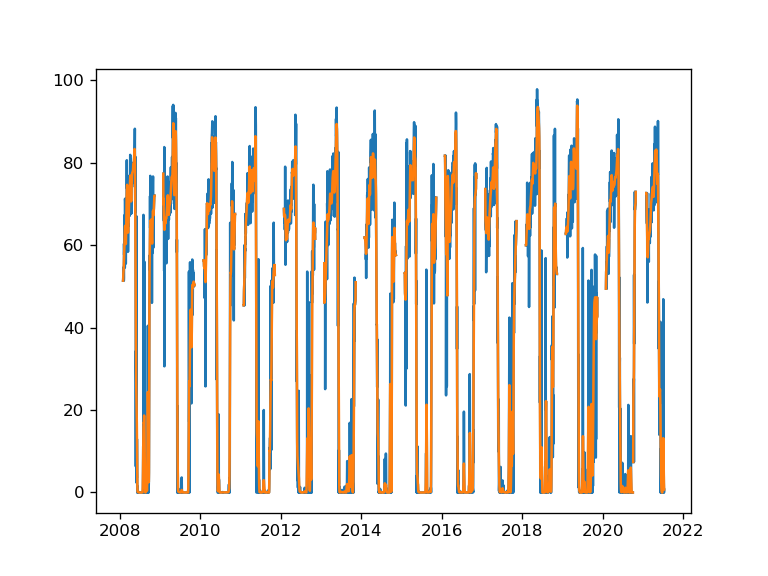

In [4]:

from sklearn.linear_model import LinearRegression
Data['Filler'] = Data['NDSI_Snow_Cover'].rolling(16,
            center=True,min_periods=1, win_type='gaussian').mean(std=3)


Temp = Data[['NDSI_Snow_Cover','Filler']].dropna()

Mod = LinearRegression()
Mod.fit(Temp[['Filler']], Temp['NDSI_Snow_Cover'])
print(Mod.score(Temp[['Filler']], Temp['NDSI_Snow_Cover']))
print(Mod.intercept_)
print(Mod.coef_)
# print(Filler)
# print(Filler)
plt.figure()
Data['FI_Snow'] = Data['NDSI_Snow_Cover'].fillna(Data['Filler'])
plt.scatter(Data['Filler'],Data['NDSI_Snow_Cover'])
# Data['']
print(Data[['NDSI_Snow_Cover','FI_Snow']].describe())


plt.figure()
plt.plot(Data['FI_Snow'])
plt.plot(Data['Filler'])

<IPython.core.display.Javascript object>


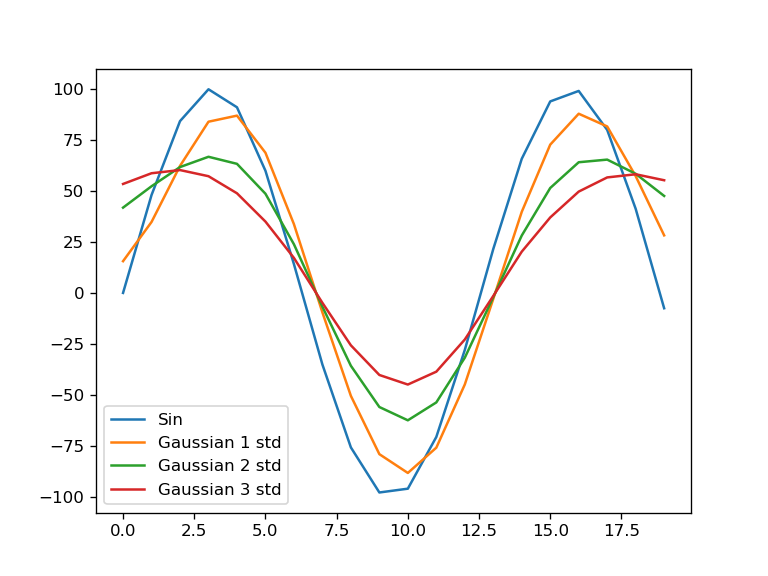

In [53]:
# Data['Test']=np.sin(Data.reset_index().index/5)
TestData = pd.DataFrame(data={'Sin':np.sin(np.arange(0,10,.5))*100})
# print(Data['Test'])
plt.figure()
plt.plot(TestData['Sin'],label='Sin')
plt.plot(TestData['Sin'].rolling(10,center=True,min_periods=3, win_type='gaussian').mean(std=1),
         label='Gaussian 1 std')
plt.plot(TestData['Sin'].rolling(10,center=True,min_periods=3, win_type='gaussian').mean(std=2),
         label='Gaussian 2 std')
plt.plot(TestData['Sin'].rolling(10,center=True,min_periods=3, win_type='gaussian').mean(std=3),
         label='Gaussian 3 std')
plt.legend()

<IPython.core.display.Javascript object>


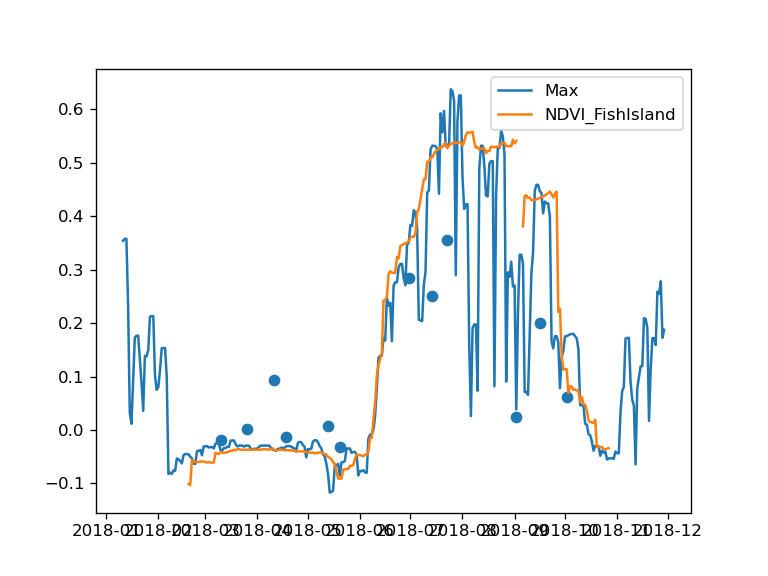

Index(['NDVI_Landsat7'], dtype='object')

In [77]:
plt.figure()
Temp = NDVI_FishIsland.loc[NDVI_FishIsland.index.year==2018]


# plt.plot(Temp['NDVI_FishIsland'].rolling(16,center=True,min_periods=8, win_type='gaussian').mean(std=2),
#          label='Gaussian 2 std')
# plt.plot(Temp['NDVI_FishIsland'].rolling(16,center=True,min_periods=8, win_type='gaussian').mean(std=3),
#          label='Gaussian 3 std')

# plt.plot(Temp['NDVI_FishIsland_Daily'].rolling(31,center=True,min_periods=8, win_type='gaussian').mean(std=3),
#          label='Gaussian 3 std')

plt.plot(Temp['NDVI_FishIsland_Daily'].rolling(3,center=True,min_periods=3).quantile(.95),
         label='Max')

# plt.plot(Temp['NDVI_FishIsland_Daily'],label='NDVI_FishIsland_Daily')
plt.plot(Temp['NDVI_FishIsland'],label='NDVI_FishIsland')


Temp = NDVI_Landsat7.loc[NDVI_Landsat7.index.year==2018]
plt.scatter(Temp.index,Temp)
plt.legend()
NDVI_Landsat7.columns

<IPython.core.display.Javascript object>


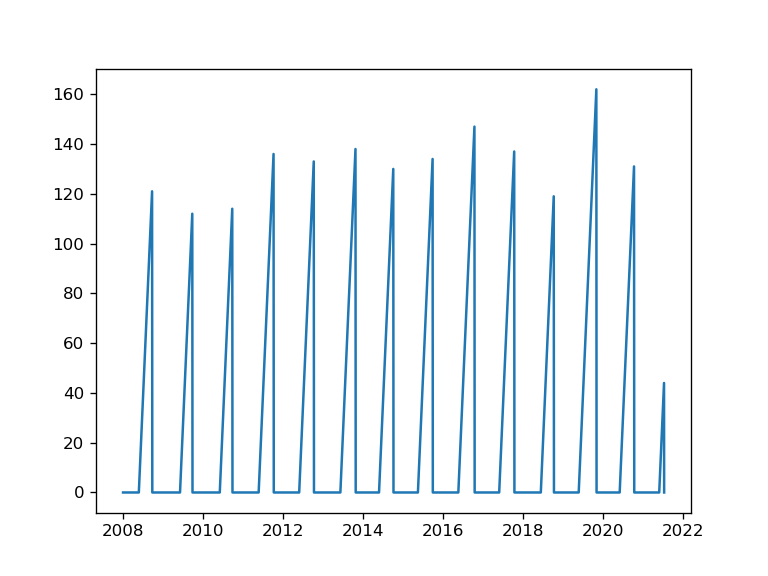

            NDVI_FishIsland  NDVI_Footprint  NDVI_Landsat7  NDVI_Landsat8  \
Date                                                                        
2008-01-01           -0.083             NaN            NaN            NaN   
2008-01-02           -0.083             NaN            NaN            NaN   
2008-01-03           -0.083             NaN            NaN            NaN   
2008-01-04           -0.083             NaN            NaN            NaN   
2008-01-05           -0.083             NaN            NaN            NaN   
...                     ...             ...            ...            ...   
2021-07-07            0.017             NaN            NaN            NaN   
2021-07-08            0.017             NaN            NaN            NaN   
2021-07-09            0.017             NaN            NaN            NaN   
2021-07-10            0.017             NaN            NaN            NaN   
2021-07-11            0.017             NaN            NaN            NaN   

In [56]:
Data['SnowFree']=Data['FI_Snow'].interpolate().bfill()
Data['SnowFree_Interp'] = 0
Data.loc[np.isnan(Data['FI_Snow'])==True,'SnowFree_Interp']=1
Data['NDVI_FishIsland']=Data['NDVI_FishIsland'].interpolate().bfill()
Data['NDVI_FishIsland_Interp'] = 0
Data.loc[np.isnan(Data['NDVI_FishIsland'])==True,'NDVI_FishIsland_Interp']=1

Thresh = 20
Data.loc[Data['SnowFree']<=Thresh,'SnowFree']=1
Data.loc[Data['SnowFree']>Thresh,'SnowFree']=-1
Data.loc[Data['SnowFree']<0,'SnowFree']=0
# Data['DSSM']=0
for Y in range(2008,2022):
    Temp = Data.loc[Data.index.year==Y].copy()
    Temp['SnowMelt'] = Temp['SnowFree'].cumsum()*Temp['SnowFree']-1
    try:
        SnowMeltDay = Temp.loc[Temp['SnowMelt']==0].index[0]
        Data.loc[Data.index >= SnowMeltDay,'Snow']=1
        SnowBackDay = Temp.loc[Temp['SnowMelt']==Temp['SnowMelt'].max()].index[0]
        Data.loc[Data.index >= SnowBackDay,'Snow']=0
        Data.loc[Data.index.year==Y,'DSSM']=Data.loc[Data.index.year==Y,'Snow'].cumsum()
    except:
        pass
Data['Snow']=Data['Snow'].fillna(0)
Data['DSSM']=Data['DSSM'].fillna(0)*Data['Snow']
plt.figure()
plt.plot(Data['DSSM'])
# print(Data.index[0:50])
print(Data)

Index(['NDVI_FishIsland', 'NDVI_Footprint', 'NDVI_Landsat7', 'NDVI_Landsat8',
       'NDVI_Landsat8_8dayComposite', 'NDSI_Snow_Cover', 'DOY', 'Filler',
       'FI_Snow', 'SnowFree', 'SnowFree_Interp', 'NDVI_FishIsland_Interp',
       'Snow', 'DSSM', 'NDVI_Al'],
      dtype='object')
            NDVI_FishIsland  NDVI_Footprint  NDVI_Landsat7  NDVI_Landsat8  \
Date                                                                        
2008-05-25           -0.060          -0.079            NaN            NaN   
2008-05-26           -0.057          -0.047            NaN            NaN   
2008-05-27           -0.060          -0.040            NaN            NaN   
2008-05-28           -0.038          -0.009            NaN            NaN   
2008-05-29           -0.024          -0.008            NaN            NaN   
...                     ...             ...            ...            ...   
2021-07-06            0.017             NaN            NaN            NaN   
2021-07-07            0

<IPython.core.display.Javascript object>


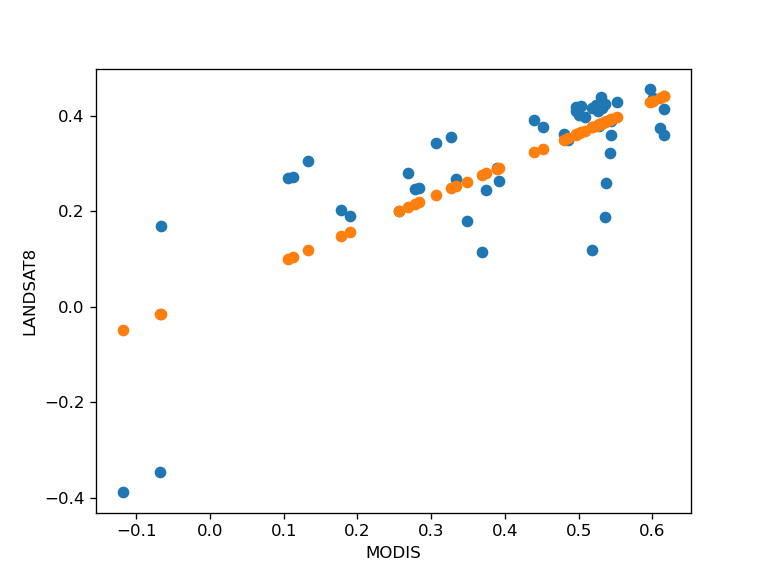

0.5730948613363568


Text(0, 0.5, 'LANDSAT8')

In [57]:

LS1 = 'NDVI_Landsat8'
LS2 = 'NDVI_Landsat8_8dayComposite'
LS = 'NDVI_Al'
Data[LS]=Data[LS1].fillna(Data[LS2])
LS = 'NDVI_Landsat8'

# LS = 'NDVI_Landsat8_8dayComposite'
# LS = 'NDVI_Landsat8'
from scipy.optimize import curve_fit
from sklearn import metrics

def Curve(x,b,c):
    return(x*b+c)
print(Data.columns)
print(Data.loc[Data.Snow==1])
Temp = Data.loc[Data.Snow==1,[LS,'NDVI_FishIsland']].dropna()
print(Temp.count())
p,r = curve_fit(Curve,Temp['NDVI_FishIsland'],Temp[LS])

print(p,r)
plt.figure()
plt.scatter(Temp['NDVI_FishIsland'],Temp[LS])
plt.scatter(Temp['NDVI_FishIsland'],Curve(Temp['NDVI_FishIsland'],*p))
print(metrics.r2_score(Temp['NDVI_FishIsland'],Curve(Temp['NDVI_FishIsland'],*p)))
plt.xlabel('MODIS')
plt.ylabel('LANDSAT8')
# print(np.sin(1))

                            OLS Regression Results                            
Dep. Variable:          NDVI_Landsat8   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     131.5
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.23e-31
Time:                        22:35:46   Log-Likelihood:                 93.797
No. Observations:                  88   AIC:                            -179.6
Df Residuals:                      84   BIC:                            -169.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1643      0.048     

<IPython.core.display.Javascript object>


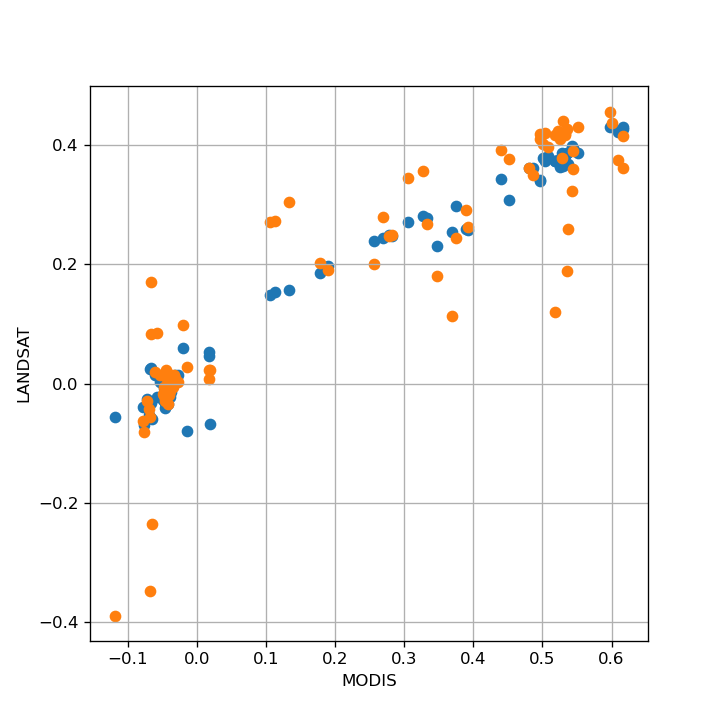

In [58]:

# Data[LS] = Data[LS].interpolate()
# Temp = Data.loc[((Data.index.month>=2)&(Data.index.month<=10)),['NDVI_FishIsland',LS,'DSSM']]#.dropna()
Bvar = 'NDSI_Snow_Cover'
Cvar = 'DOY'
Temp = Data[['NDVI_FishIsland',LS,Bvar,Cvar]].dropna()
# print(Temp)
X = Temp[['NDVI_FishIsland',Bvar,Cvar]]
Y = Temp[LS]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())
fig,ax=plt.subplots(figsize=(6,6))
# Temp = Data.loc[((Data['DSSM']>=1))]
Est = results.params[0]+Temp['NDVI_FishIsland']*results.params[1]+Temp[Bvar]*results.params[2]+Temp[Cvar]*results.params[3]
Data['NDVI']=results.params[0]+Data['NDVI_FishIsland']*results.params[1]+Data[Bvar]*results.params[2]+Data[Cvar]*results.params[3]
ax.scatter(Temp['NDVI_FishIsland'],Est)
ax.scatter(Temp['NDVI_FishIsland'],Temp[LS])

# ax.scatter(Data['NDVI_FishIsland'],Data[LS1])
ax.set_xlabel('MODIS')
ax.set_ylabel('LANDSAT')
ax.grid()

<IPython.core.display.Javascript object>


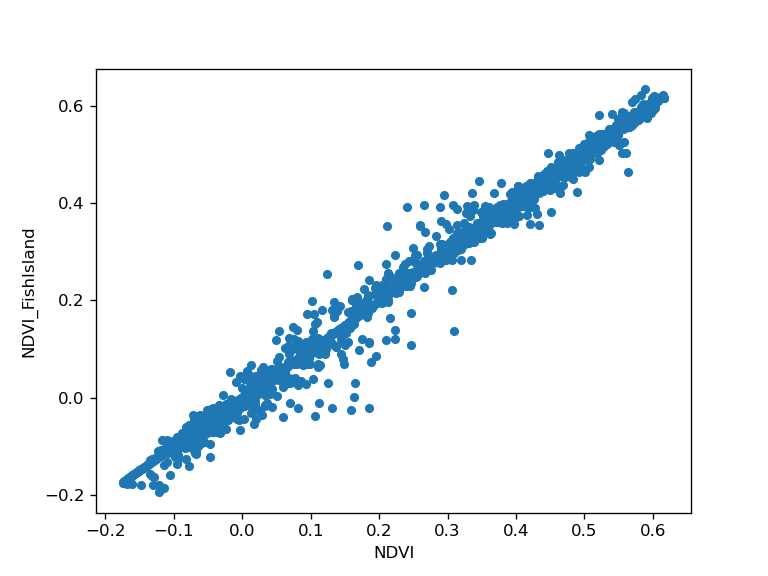

In [74]:
# Data_Days.loc[Data_Days['NDVI']<0,'NDVI']=0
# Data_Days.loc[Data_Days['Angle']>-0.83,'Daytime']=1
Data['NDVI']=Data['NDVI_FishIsland'].rolling(16,center=True,min_periods=3, win_type='gaussian').mean(std=3)
Data=Data.drop('DOY',axis=1)
Data.to_csv('SatSun.csv')
fig,ax=plt.subplots()
Data.plot(kind='scatter',x='NDVI',y='NDVI_FishIsland',ax=ax)

In [71]:
Data = Data[Data.index.duplicated()==False]
Data = Data.loc[Data.index<'2020-12-31']

In [72]:


from math import floor
Data['JD'] = Data.index.to_julian_date()
Data['Date'] = Data.index.copy()
LAT = 69.36666
LON = -134.86
TZ = -7
Data_Days = Data.resample('15T').asfreq()# .loc[((Data.index.year==2017)&(Data.index.month==8))]
Data_Days[['JD','Date']]=Data_Days[['JD','Date']].ffill()
Data_Days[['JD','Date']]=Data_Days[['JD','Date']].bfill()
Data_Days[['NDVI','DSSM']]=Data_Days[['NDVI_FishIsland','DSSM']].interpolate()
Data_Days['Daytime']=0
print(Data_Days.shape)
# prog = FloatProgress(min=0, max=Data_Days.shape[0],description='Prog:')
# prog.value=0
# display(prog)
# for i,row in Data_Days.iterrows():
# #     print()
#     prog.value+=1
#     Time = (i.hour+i.minute/60)/24
# #     print()
# #     print(row['JD'],Time)
#     Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SunStas(LAT,LON,row['JD'],Time,TZ)
# #     print(i.hour+i.minute/60,Sunrise*24,Sunset*24,Angle_Corr)
#     Data_Days.loc[Data_Days.index==i,'Angle'] = Angle_Corr
    
# Data_Days = Data_Days[Data_Days.index.duplicated()==False]

# print('Done')
# # print(Data_Days['Daytime'].sum()/2)
Data_Days = Data_Days.resample('30T').mean()
# print(Data_Days['Daytime'].sum())


(455713, 19)


                         NDVI  DSSM  Daytime
Date                                        
2017-01-01 00:00:00  0.000854   0.0        0
2017-01-01 00:30:00  0.000837   0.0        0
2017-01-01 01:00:00  0.000820   0.0        0
2017-01-01 01:30:00  0.000803   0.0        0
2017-01-01 02:00:00  0.000786   0.0        0
...                       ...   ...      ...
2017-12-31 21:30:00  0.045155   0.0        0
2017-12-31 22:00:00  0.045093   0.0        0
2017-12-31 22:30:00  0.045031   0.0        0
2017-12-31 23:00:00  0.044969   0.0        0
2017-12-31 23:30:00  0.044907   0.0        0

[17520 rows x 3 columns]


<IPython.core.display.Javascript object>


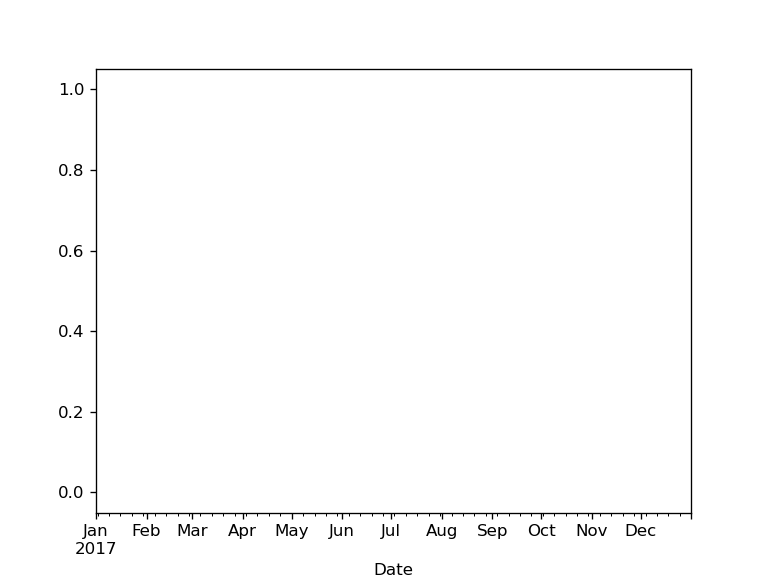

(0, 18)
(0, 18)
NDVI_FishIsland                  365
NDVI_Footprint                   235
NDVI_Landsat7                     16
NDVI_Landsat8                     11
NDVI_Landsat8_8dayComposite       17
NDSI_Snow_Cover                  153
DOY                              365
Filler                           285
FI_Snow                          285
SnowFree                         365
SnowFree_Interp                  365
NDVI_FishIsland_Interp           365
Snow                             365
DSSM                           17520
NDVI_Al                           24
NDVI                           17520
JD                             17520
Daytime                        17520
dtype: int64


In [73]:

# print(Data_Days.index.day)
Temp = Data_Days.loc[Data_Days.index.year==2017].resample('30T').mean()#
# Temp.to_csv('SatSun.csv')
# print(Temp[['NDVI','DSSM','Daytime']].resample('30T').max())
# print(Data_Days[['NDVI','DSSM','Daytime']].resample('30T').mean())
print(Temp[['NDVI','DSSM','Daytime']])
plt.figure()
Temp['Snow'].plot()
print(Data_Days.loc[np.isnan(Data_Days['Daytime'])==True].shape)
print(Temp.loc[np.isnan(Temp['Daytime'])==True].shape)
print(Data_Days.loc[Data_Days.index.year==2017].count())

In [10]:
%matplotlib notebook
# import sys
# import os
# import time
# import numpy as np
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point, Polygon, MultiPolygon, shape
import rasterio
from rasterio import features
from rasterio.transform import from_origin
# from matplotlib import pyplot as plt
from geopandas import GeoDataFrame
# from datetime import datetime
# import datetime
from rasterio.plot import show
import numpy as np
# import Footprint_Processing as FP
# import importlib
# importlib.reload(FP)
# # print('Kitty')

<IPython.core.display.Javascript object>


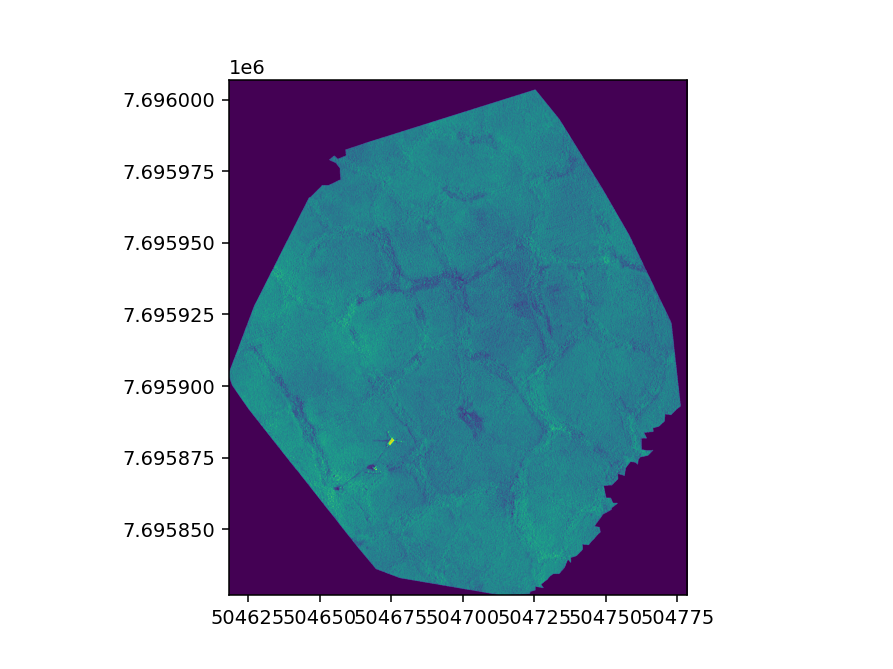

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 1600, 'height': 1801, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(0.09999099840199051, 0.0, 504618.2476426054,
       0.0, -0.09999099840199051, 7696006.9916277295), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 1600, 'height': 1801, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(0.09999099840199051, 0.0, 504618.2476426054,
       0.0, -0.09999099840199051, 7696006.9916277295), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 1600, 'height': 1801, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(0.09999099840199051, 0.0, 504618.2476426054,
       0.0, -0.09999099840199051, 7696006.9916277295), 'blockxsize': 128, 'blocky

In [71]:
# fig,ax = plt.subplots()
def Standard(B):
#     print(B)
#     print(np.nanmean(B),np.nanstd(B))
    B = (B-np.nanmean(B))/(np.nanstd(B))
    return(B)
Img = ['6_23','7_12','8_21','9_13']
for img in Img:
    with rasterio.open('C:\\FishIsland_2017\\Pictures/'+img+'.tif','r') as Im:
    #     plt.colorbar()
        R = Im.read(1).astype(float)
        G = Im.read(2).astype(float)
        B = Im.read(3).astype(float)
        A = Im.read(4).astype(float)

        Sum = R+G+B
        B = G/Sum
    #     print(G.dtype,Sum.max())

        GS = Standard(B)
        print(np.nanmean(B))
        show(B)

        print(Im.profile)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


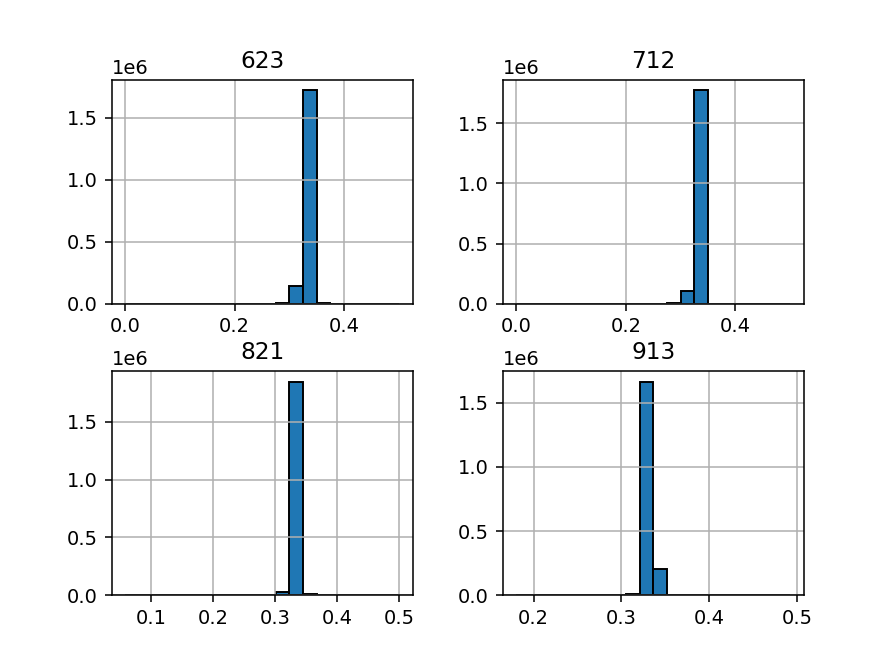

,623,712,821,913
count,1.883017e+06,1.883029e+06,1.883029e+06,1.883029e+06
mean,3.312103e-01,3.303871e-01,3.321172e-01,3.326043e-01
std,6.249744e-03,4.768149e-03,4.026245e-03,3.805897e-03
min,0.000000e+00,0.000000e+00,5.769231e-02,1.805930e-01
25%,3.289902e-01,3.287037e-01,3.300971e-01,3.308081e-01
50%,3.314448e-01,3.304158e-01,3.319920e-01,3.326039e-01
75%,3.333333e-01,3.325416e-01,3.340611e-01,3.342318e-01
max,5.000000e-01,5.000000e-01,5.000000e-01,4.919094e-01


In [134]:
# import rasterio
# from rasterio.enums import Resampling

# upscale_factor = 2
# plt.figure()
D = '623'
def Standard(D):
    R =  rasterio.open("C:\\FishIsland_2017\\Pictures/Overlap/"+D+"_1")
    R = R.read(1).astype('float')
    G =  rasterio.open("C:\\FishIsland_2017\\Pictures/Overlap/"+D+"_2")
    G = G.read(1).astype('float')
    B =  rasterio.open("C:\\FishIsland_2017\\Pictures/Overlap/"+D+"_2")
    B = B.read(1).astype('float')
    Sum = R+G+B
    S = G/Sum
    return(S)
Img_623 = Standard('623')
Img_712 = Standard('712')
Img_821 = Standard('821')
Img_913 = Standard('913')
# print(np.nanmean(Img_712))
# print(np.nanmax(Img))
# print(np.nanmin(Img))
# print()
# show(Img_821)

Data = pd.DataFrame(data={'623':Img_623.flatten(),
'712':Img_712.flatten(),
'821':Img_821.flatten(),
'913':Img_913.flatten()})
from scipy import stats
# Data = Data[(np.abs(stats.zscore(Data)) < 3).all(axis=1)]

# Data.loc[((Data['623']<.2)|Data['623']>.5)]=np.nan
# Data[Data<.3]=np.nan
# Data[Data>.36]=np.nan


# Data = Data


# fig,ax = plt.subplots()
# ax.hist(Img_821.flatten(),bins=10,edgecolor='k')

Data.hist(bins=20,edgecolor='k')
Data.describe()

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
import fiona
import rasterio as rio
from rasterio.mask import mask
import gdal
import shapely
from shapely.geometry import mapping, shape, MultiPolygon, Polygon
from shapely.ops import transform
import pyproj

def gdal_reproject(src_path, dist_path, dst_crs, bounds, dst_res=(30, 30), interp=0, align=True):
    opt = gdal.WarpOptions(dstSRS=dst_crs,
                           outputBounds=bounds,
                           polynomialOrder=interp,
                           targetAlignedPixels=align,
                           xRes=dst_res[0], yRes=dst_res[1])
    gdal.Warp(srcDSOrSrcDSTab=src_path, 
              destNameOrDestDS=dist_path, 
              options=opt)


def summarize_tif(path):
    tif1 = rio.open(path)
    x_res = (tif1.bounds.right - tif1.bounds.left) / tif1.width
    y_res = (tif1.bounds.top - tif1.bounds.bottom) / tif1.height
    print("crs {}".format(tif1.crs))
    print('dtype {}'.format(tif1.meta['dtype']))
    print("height {}, width {}".format(tif1.height, tif1.width))
    print("x_res {}, y_res {}".format(x_res, y_res))
    print("bounds {} \n \n".format(tif1.bounds))
    tif1.close()


tif_1 = "C:\\FishIsland_2017\\Pictures/Overlap.tif"#join(landsat_dir, "21_32/LC080210322016072801T1/LC08_L1TP_021032_20160728_20170221_01_T1_sr_band3.tif")
summarize_tif(tif_1)
#  crs EPSG:32616
#  dtype int16
#  height 7801, width 7671
#  x_res 30.0, y_res 30.0
#  bounds BoundingBox(left=497085.0, bottom=4347885.0, right=727215.0, top=4581915.0) 

with rio.open(tif_1, 'r') as tif:
    dst_crs = tif.crs


tif_2 = 'C:\\FishIsland_2017\\Pictures/'+img+'.tif'#join(CLD_dir, "CDL_2018_18.tif")
summarize_tif(tif_2)
#  crs PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
#  dtype uint8
#  height 15717, width 9143
#  x_res 30.0, y_res 30.0
#  bounds BoundingBox(left=687435.0, bottom=1666935.0, right=961725.0, top=2138445.0) 

tif_2_reproj = 'C:\\FishIsland_2017\\Pictures/Test.tif'#join(tmp_dir, "usda_2018_18_EPSG32616_gdal_py.tif")

if os.path.isfile(tif_2_reproj):
    os.remove(tif_2_reproj)
gdal_reproject(src_path=tif_2, dist_path=tif_2_reproj, bounds=src_bounds,
               dst_crs=dst_crs, dst_res=(30, 30), interp=0, align=False)
summarize_tif(tif_2_reproj)


# if os.path.isfile(tif_2_reproj):
#     os.remove(tif_2_reproj)
# gdal_reproject(src_path=tif_2, dist_path=tif_2_reproj, 
#                dst_crs=dst_crs, dst_res=(30, 30), interp=0, align=True)
# summarize_tif(tif_2_reproj)
#  crs EPSG:32616
#  dtype uint8
#  height 16358, width 10673
#  x_res 30.0, y_res 30.0
#  bounds BoundingBox(left=402150.0, bottom=4156530.0, right=722340.0, 
#  top=4647270.0) 

with fiona.open(parc_2018, layer='County_Land_Parcels_IGIO_IN_Apr2018') as src:
    meta = src.meta
    print('src crs', src.crs)
    src_crs = src.crs['init']
    for i, feature in enumerate(src):
        if i==200423:
            polys = shape(feature['geometry'])
            print(type(polys))
            polys_rpj = shapely.ops.transform(lambda xx, y: pyproj.transform(pyproj.Proj(init=src_crs), 
                                                                      pyproj.Proj(init=dst_crs), xx, y), 
                                                                      polys)
            print(type(polys_rpj))
            print('poly center: {}'.format(polys_rpj.centroid))
            with rio.open(tif_1, 'r') as tif:
                crop1, trnsfrm1 = mask(dataset=tif, shapes=[polys_rpj],crop=True)

            with rio.open(tif_2_reproj, 'r') as tif:
                crop2, trnsfrm2 = mask(dataset=tif, shapes=[polys_rpj],crop=True)


            break

print("crop1 shape {}, crop2 shape {}".format(crop1.shape, crop2.shape))

#  <class 'shapely.geometry.multipolygon.MultiPolygon'>
#  <class 'shapely.geometry.multipolygon.MultiPolygon'>
#  poly center: POINT (669672.4700203884 4369366.759086045)
#  src crs {'init': 'epsg:26916'}, dst crs EPSG:32616
#  crop1 shape (1, 4, 3), crop2 shape (1, 5, 3)



crs EPSG:32608
dtype uint16
height 1801, width 1600
x_res 0.09999099840199051, y_res 0.09999099840202691
bounds BoundingBox(left=504618.2476426054, bottom=7695826.907839607, right=504778.2332400486, top=7696006.9916277295) 
 

crs EPSG:32608
dtype uint8
height 3379, width 2823
x_res 0.09999099840200398, y_res 0.09998930595731394
bounds BoundingBox(left=504495.9761633433, bottom=7695671.753143947, right=504778.25075183215, top=7696009.617008776) 
 



NameError: name 'src_bounds' is not defined